<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Oil_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [ ]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


In [ ]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [ ]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

In [ ]:

OilPriceInUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
OilPriceInUSD['Date'] = pd.to_datetime(OilPriceInUSD['Date']).dt.date
OilPriceInUSD.set_index('Date', inplace=True)
OilPriceInUSD

OilPriceInUSD=OilPriceInUSD.asfreq('b')
OilPriceInUSD['Original_Oil_Price']=OilPriceInUSD.Value.fillna(method='bfill')
df_Oil_InUSD=OilPriceInUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09
...,...
2023-06-29,74.34
2023-06-30,76.14
2023-07-03,76.12


In [ ]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



In [ ]:
perform_adfuller(OilPriceInUSD['Original_Oil_Price'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -6.846744550080828
P-value: 1.7350328765829617e-09
The time series is stationary.


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


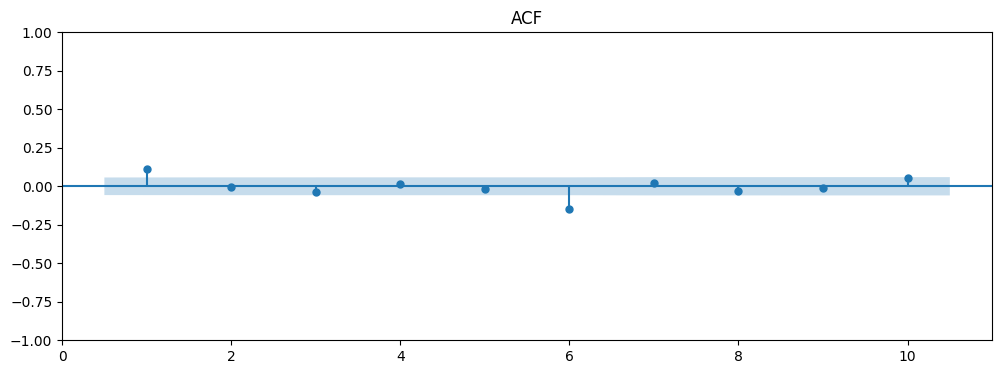

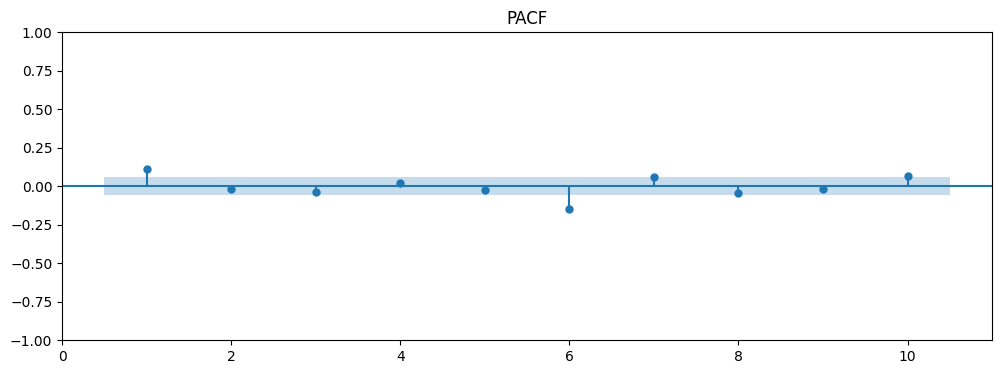

In [ ]:
plot_acf_values(OilPriceInUSD['Original_Oil_Price'].diff(1),10)
plot_pacf_values(OilPriceInUSD['Original_Oil_Price'].diff(1),10)

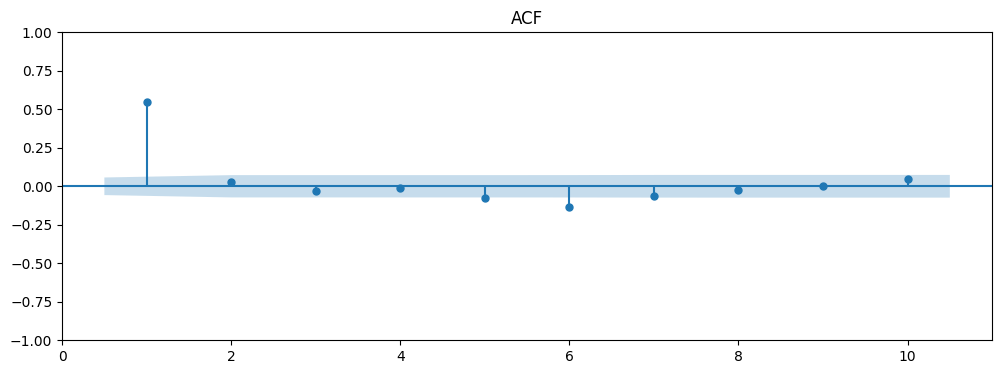

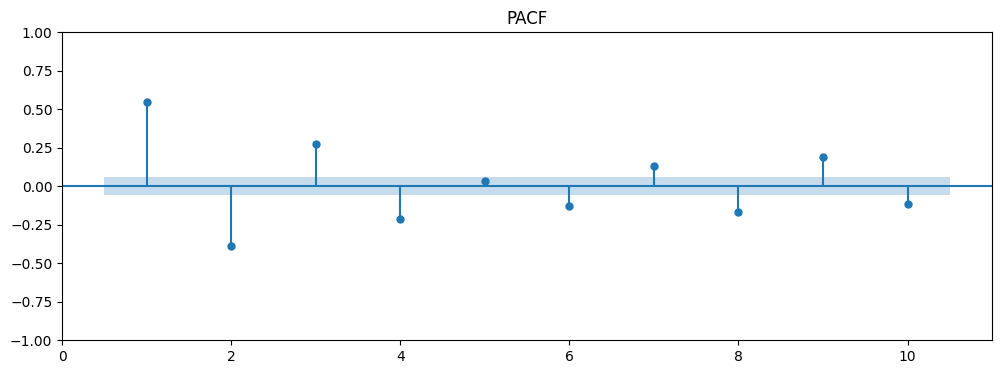

In [ ]:
plot_acf_values(OilPriceInUSD['Original_Oil_Price'].diff(2),10)
plot_pacf_values(OilPriceInUSD['Original_Oil_Price'].diff(2),10)

In [ ]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime('2019-01-01')
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [ ]:
train_data_oil = df_Oil_InUSD[(df_Oil_InUSD.index >= train_start_date) & (df_Oil_InUSD.index <= train_end_date)]
test_data_oil = df_Oil_InUSD[df_Oil_InUSD.index >= test_start_date]
train_data_oil.head(5)



,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09


In [ ]:
from pmdarima import auto_arima
model = auto_arima(train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5, start_d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4031.353, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4018.777, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4020.684, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4020.532, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4022.532, Time=0.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4023.944, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4018.836, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4020.721, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4022.438, Time=1.77 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4022.532, Time=1.55 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4013.416, Time=2.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4020.649, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4020.573, Time=2.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4010.821, Time=2.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4020.136, Time=4.91 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1991.204
Date:                Fri, 07 Jul 2023   AIC                           3996.409
Time:                        08:27:23   BIC                           4031.051
Sample:                    01-02-2019   HQIC                          4009.549
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0826      0.182      0.453      0.650      -0.275       0.440
ar.L1         -1.4324      0.035    -40.948      0.000      -1.501      -1.364
ar.L2         -0.6520      0.049    -13.231      0.000      -0.749      -0.555
ar.L3          0.1782      0.023      7.791      0.000       0.133       0.223
ma.L1          1.5645      0.026     61.339      0.000       1.514       1.614
ma.L2          0.9130      0.026     35.323      0.000       0.862       0.964
sigma2         2.6742      0.051     52.099      0.000       2.574       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              5422.76
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(3,1,2))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                 1043
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1991.314
Date:                Fri, 07 Jul 2023   AIC                           3994.629
Time:                        08:27:27   BIC                           4024.322
Sample:                    01-02-2019   HQIC                          4005.892
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4321      0.035    -40.972      0.000      -1.501      -1.364
ar.L2         -0.6516      0.049    -13.242      0.000      -0.748      -0.555
ar.L3          0.1785      0.023      7.852      0.000       0.134       0.223
ma.L1          1.5644      0.025     61.617      0.000       1.515       1.614
ma.L2          0.9130      0.026     35.529      0.000       0.863       0.963
sigma2         2.6749      0.051     52.365      0.000       2.575       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              5421.92
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

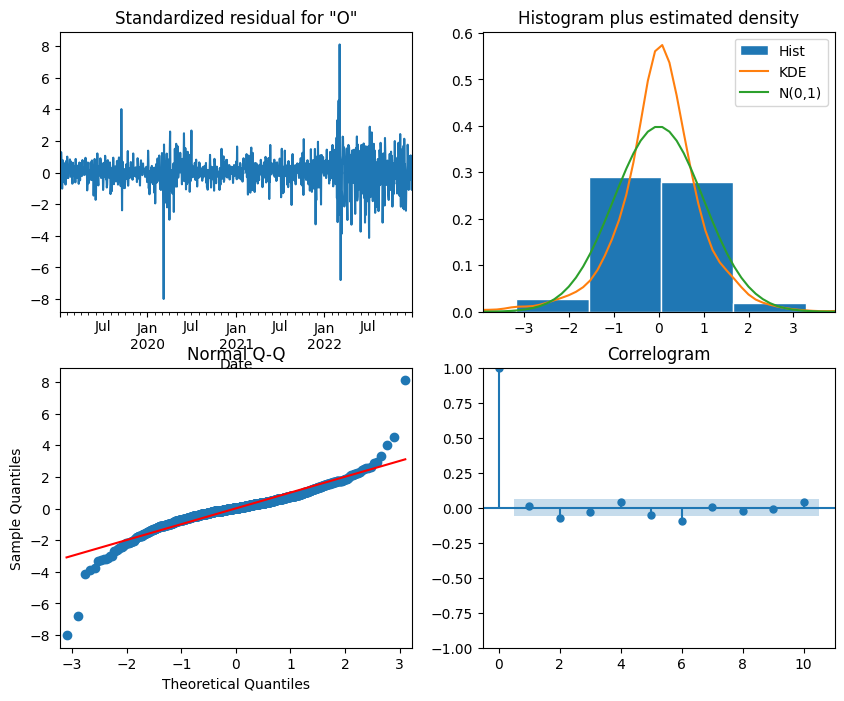

In [ ]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [ ]:
# Get in-sample predictions
training_data_predictions = oil_model_fit.get_prediction(start=train_data_oil.dropna().index.min(),
                                                      end=train_data_oil.dropna().index.max(),
                                                      dynamic=False)

train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_oil['Oil predictions'] = training_data_predictions.predicted_mean

train_data_oil

,Original_Oil_Price,lower Oil predictions,Higher Oil predictions,Oil predictions
Date,,,,
2019-01-02,52.14,-1959.966721,1959.966721,0.000000
2019-01-03,52.93,48.865015,55.415020,52.140017
2019-01-04,55.13,49.771705,56.275554,53.023629
2019-01-07,56.42,52.177396,58.668988,55.423192
2019-01-08,56.09,53.443444,59.933541,56.688492
...,...,...,...,...
2022-12-26,82.23,77.247193,83.658265,80.452729
2022-12-27,82.23,79.455459,85.866531,82.660995
2022-12-28,81.96,78.797827,85.208899,82.003363


In [ ]:
forecast = oil_model_fit.get_forecast(steps=5, alpha=0.05)
forecast.predicted_mean

2023-01-02    81.399469
2023-01-03    81.576954
2023-01-04    81.412067
2023-01-05    81.552095
2023-01-06    81.490670
Freq: B, Name: predicted_mean, dtype: float64

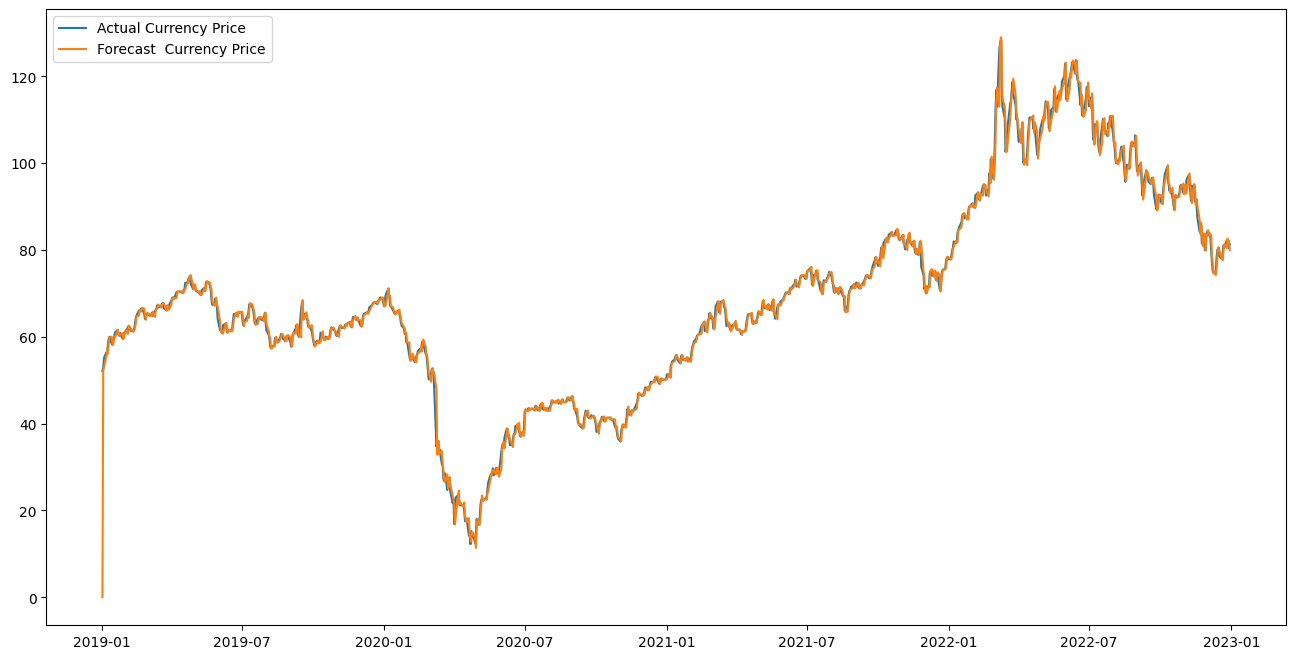

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(train_data_oil['Oil predictions'],label="Forecast  Currency Price")
plt.legend(loc="upper left")

In [ ]:
test_data_oil

,Original_Oil_Price
Date,
2023-01-02,82.05
2023-01-03,82.05
2023-01-04,76.88
2023-01-05,75.77
2023-01-06,76.15
...,...
2023-06-29,74.34
2023-06-30,76.14
2023-07-03,76.12


In [ ]:
import pandas as pd

# define train test data
train = train_data_oil['Original_Oil_Price'].dropna()
test = test_data_oil['Original_Oil_Price'].dropna()

# define model configuration
my_order = (3,1,2)

# lists to collect forecasts
forecasts = []
forecast_dates = []

# walk-forward validation
history = [x for x in train]
for i in range(len(test)):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
      #my_order = auto.order
      #print("my_order is {} for date {} is {}".format(my_order,test.index[i],forecast.predicted_mean[0]))
      model = ARIMA(history, order=my_order)
      model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    forecast_dates.append(test.index[i])
    history.append(forecast.predicted_mean[0])
    #print("Mean is {} for date {}".format(forecast.predicted_mean[0],test.index[i]))
    #print("Length of History is {} for date{} and order {} forecast is {}",format((len(history),test.index[i],my_order,forecast.predicted_mean[0])))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=forecast_dates)



In [ ]:
forecast_df

,Forecast
2023-01-02,81.399469
2023-01-03,81.399469
2023-01-04,81.399469
2023-01-05,81.399469
2023-01-06,81.399469
...,...
2023-06-29,81.470871
2023-06-30,81.470871
2023-07-03,81.471440
2023-07-04,81.471440


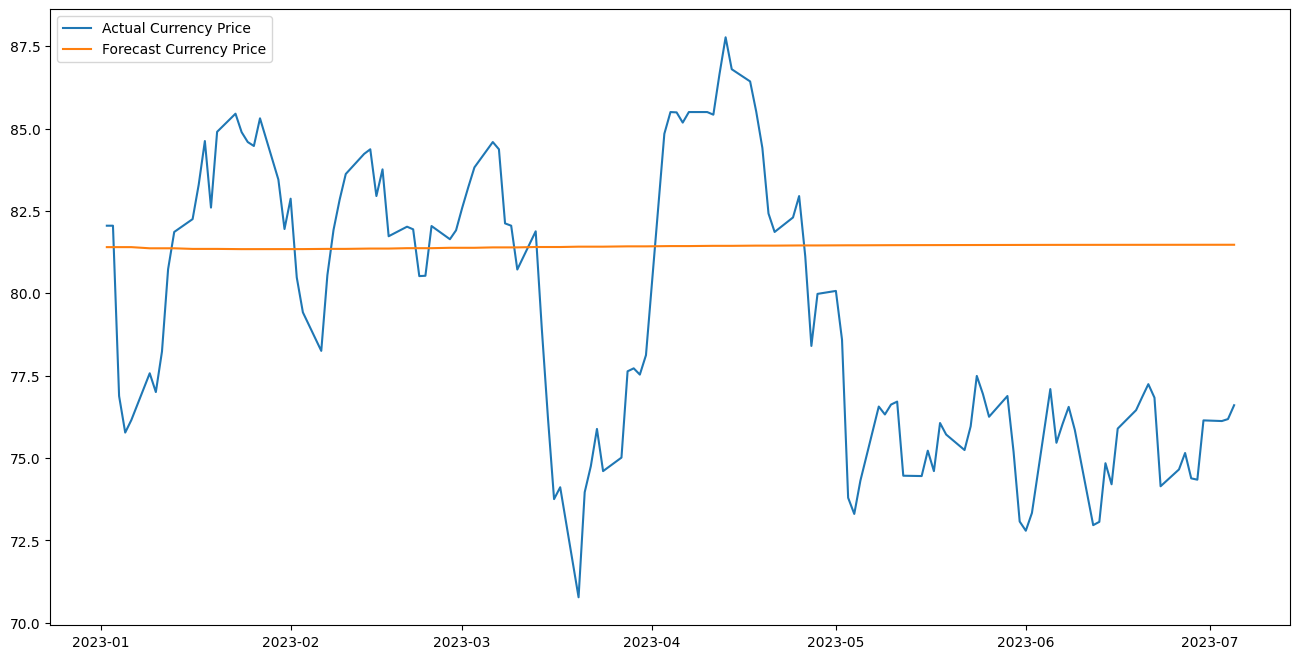

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}




In [ ]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 3.9950064366824733,
 'Mean Squared Error': 21.738083142922278,
 'Root Mean Squared Error': 4.662411730308927,
 'Mean Absolute Percentage Error': 5.163559347728248}